In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving “EV Vehicle dataset.csv to “EV Vehicle dataset (1).csv
User uploaded file "“EV Vehicle dataset (1).csv" with length 1216895 bytes


In [ ]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [ ]:
df = pd.read_csv(r"“EV Vehicle dataset.csv")



In [24]:
df.head(10)


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19
5,May 31 2018,Maui,HI,Passenger,1,0,1,59,60,1.67
6,November 30 2017,Northampton,PA,Passenger,0,1,1,66,67,1.49
7,March 31 2018,Nassau,NY,Passenger,1,0,1,37,38,2.63
8,March 31 2020,DeKalb,IN,Passenger,1,0,1,1,2,50.00
9,January 31 2019,Columbia,WA,Truck,0,0,0,"1,529","1,529",0.00


In [ ]:
df.shape


(20819, 10)

In [25]:
df. info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [ ]:
df.isnull().sum()

,0
Date,0
County,86
State,86
Vehicle Primary Use,0
Battery Electric Vehicles (BEVs),0
Plug-In Hybrid Electric Vehicles (PHEVs),0
Electric Vehicle (EV) Total,0
Non-Electric Vehicle Total,0
Total Vehicles,0
Percent Electric Vehicles,0


In [ ]:
# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


<Axes: ylabel='Percent Electric Vehicles'>

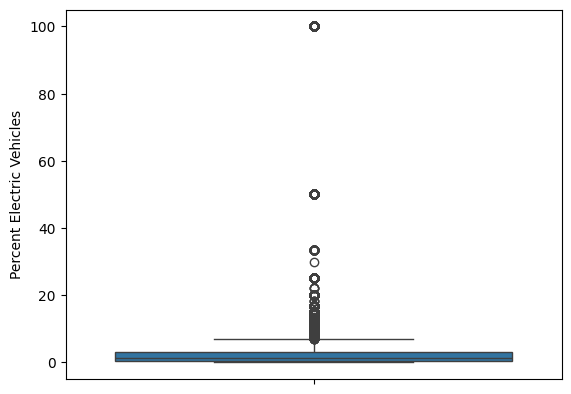

In [30]:
import seaborn as sns
sns.boxplot(df['Percent Electric Vehicles'])


In [31]:
# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Group by Date and aggregate EV count
monthly_ev = df.groupby('Date')['Electric Vehicle (EV) Total'].sum().reset_index()


In [33]:
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

Missing after fill:
County    0
State     0
dtype: int64


In [35]:
df.head(10)

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
8970,2017-01-31,Contra Costa,CA,Passenger,1,0,1,676,677,0.15
3493,2017-01-31,Island,WA,Truck,1,0,1,"20,515","20,516",0.00
20411,2017-01-31,Volusia,FL,Passenger,0,1,1,52,53,1.89
7518,2017-01-31,Mason,WA,Truck,0,0,0,"19,182","19,182",0.00
10779,2017-01-31,Pierce,WA,Passenger,822,751,"1,573","528,213","529,786",0.30
4356,2017-01-31,Unknown,Unknown,Passenger,2,0,2,484,486,0.41
2275,2017-01-31,Hawaii,HI,Passenger,1,0,1,92,93,1.08
16608,2017-01-31,Durham,NC,Passenger,0,1,1,39,40,2.50
19651,2017-01-31,El Paso,CO,Passenger,1,1,2,886,888,0.23
5236,2017-01-31,Ferry,WA,Truck,0,0,0,"3,581","3,581",0.00
